In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import torch
import random
from IPython import display
from matplotlib import pyplot as plt
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
warnings.filterwarnings("ignore")

In [ ]:
# 定义dataset
class my_Dataset(data.Dataset):
  def __init__(self, features, labels):
    self.X = features
    self.y = labels

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

In [ ]:
class TrafficDataset:
  def __init__(self, sensor=10, target=0):
    # 选取适当的检测器用作序列数据
    self.raw_data = np.load('/content/traffic.npz')['data']
    self.sensor = sensor
    self.target = target
    # 数据标准化
    self.min = self.raw_data.min()
    self.max = self.raw_data.max()
    self.data = (self.raw_data - self.min) / (self.max - self.min)

  def denormalize(self, x):
    return x * (self.max - self.min) + self.min

  def construct_set(self, train_por = 0.6, test_por = 0.2, window_size = 12, label=0):
    # 预测车流量 选取1号传感器，滑动窗口大小设置为12
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    sensor_num = 1

    # 补全构造过程
    #训练集
    len_train = int(self.data.shape[0] * train_por)
    train_seqs = self.data[:len_train]
    for i in range(train_seqs.shape[0] - window_size):
      train_x.append(train_seqs[i:i + window_size, sensor_num, :].squeeze())
      train_y.append(train_seqs[i + window_size, sensor_num, label].squeeze())

    # train_x = torch.Tensor(train_x)
    # train_y = torch.Tensor(train_y)
    #验证集
    len_val = int(self.data.shape[0] * (train_por+test_por))
    val_seqs = self.data[len_train:len_val]
    for i in range(val_seqs.shape[0] - window_size):
      val_x.append(val_seqs[i:i + window_size, sensor_num, :].squeeze())
      val_y.append(val_seqs[i + window_size, sensor_num, label].squeeze())

    # val_x = torch.Tensor(val_x)
    # val_y = torch.Tensor(val_y)
    #测试集
    test_seqs = self.data[len_val:]
    for i in range(test_seqs.shape[0] - window_size):
      test_x.append(test_seqs[i:i + window_size, sensor_num, :].squeeze())
      test_y.append(test_seqs[i + window_size, sensor_num, label].squeeze())

    # test_x = torch.Tensor(test_x)
    # test_y = torch.Tensor(test_y)

    train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
    val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
    test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
    return train_set, val_set, test_set

In [ ]:
def mape_fn(y, pred):
  mask = y != 0
  y = y[mask]
  pred = pred[mask]
  mape = np.abs((y - pred) / y)
  mape = np.mean(mape) * 100
  return mape


def eval(y, pred):
  y = y.cpu().numpy()
  pred = pred.cpu().numpy()
  mse = mse_fn(y, pred)
  rmse = math.sqrt(mse)
  mae = mae_fn(y, pred)
  mape = mape_fn(y, pred)
  return [rmse, mae, mape]


In [ ]:
def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
  x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
  plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
  plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


def plot_metric(score_log):
  score_log = np.array(score_log)

  plt.figure(figsize=(10, 6), dpi=300)
  plt.subplot(2, 2, 1)
  plt.plot(score_log[:, 0], c='#d28ad4')
  plt.ylabel('RMSE')

  plt.subplot(2, 2, 2)
  plt.plot(score_log[:, 1], c='#e765eb')
  plt.ylabel('MAE')

  plt.subplot(2, 2, 3)
  plt.plot(score_log[:, 2], c='#6b016d')
  plt.ylabel('MAPE')

  plt.show()

def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
  for i in args:
    x = np.linspace(0,len(i[0]),len(i[0]))
    plt.plot(x,i[0],label=i[1],linewidth=1.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()

In [ ]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
def mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  non_zero_index = (y_true > 0)
  y_true = y_true[non_zero_index]
  y_pred = y_pred[non_zero_index]

  mape = np.abs((y_true - y_pred) / y_true)
  mape[np.isinf(mape)] = 0
  return np.mean(mape) * 100

In [ ]:
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
  rmse, mae, mape = 0, 0, 0
  batch_count = 0
  total_loss = 0.0
  net.eval()
  if output_model is not None:
    output_model.eval()
  for X, Y in data_iter:
    X = X.to(device).float()
    Y = Y.to(device).float()
    output, hidden = net(X)
    if output_model is not None:
      y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
    else:
      y_hat = output[:, -1, :].squeeze(-1)
    loss = loss_fn(y_hat, Y)

    Y = denormalize_fn(Y)
    y_hat = denormalize_fn(y_hat)
    a, b, c = eval(Y.detach(), y_hat.detach())
    rmse += a
    mae += b
    mape += c
    total_loss += loss.detach().cpu().numpy().tolist()
    batch_count += 1
  return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [ ]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
  train_loss_lst = []
  val_loss_lst = []
  train_score_lst = []
  val_score_lst = []
  epoch_time = []

  best_epoch = 0
  best_val_rmse = 9999
  early_stop_flag = 0
  for epoch in range(num_epoch):
    net.train()
    if output_model is not None:
      output_model.train()
    epoch_loss = 0
    batch_count = 0
    batch_time = []
    rmse, mae, mape = 0, 0, 0
    for X, Y in train_iter:
      batch_s = time.time()
      X = X.to(device).float()
      Y = Y.to(device).float()
      optimizer.zero_grad()
      output, hidden = net(X)
      if output_model is not None:
        y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
      else:
        y_hat = output[:, -1, :].squeeze(-1)
      # print('---------------------------------------------')
      # print(y_hat,Y)
      # print('--------------------------------------------')
      loss = loss_fn(y_hat, Y)
      loss.backward()
      optimizer.step()

      Y = denormalize_fn(Y)
      y_hat = denormalize_fn(y_hat)
      a, b, c = eval(Y.detach(), y_hat.detach())
      rmse += a
      mae += b
      mape += c
      epoch_loss += loss.detach().cpu().numpy().tolist()
      batch_count += 1
      # sample_num += X.shape[0]

      batch_time.append(time.time() - batch_s)
      if is_print and is_print_batch:
        print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %(epoch + 1, batch_count, epoch_loss, batch_time[-1]))

    train_loss = epoch_loss / batch_count
    train_loss_lst.append(train_loss)
    train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

    # 验证集
    val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
    val_score_lst.append(val_score)
    val_loss_lst.append(val_loss)

    epoch_time.append(np.array(batch_time).sum())

    # 打印本轮训练结果
    if is_print:
      print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
          (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 早停
    if val_score[0] < best_val_rmse:
      best_val_rmse = val_score[0]
      best_epoch = epoch
      early_stop_flag = 0
    else:
      early_stop_flag += 1
      if early_stop_flag == early_stop:
        print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
        break

  # 输出最终训练结果
  print(f'\n{"*" * 40}\nFinal result:')
  print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
  print(f'Total time {np.array(epoch_time).sum():.2f}s')
  print()

  # 计算测试集效果
  test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
  print('Test result:')
  print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
  return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=40, device=device, output_model=out_linear)

*** epoch1, train loss 0.1012, train rmse 360.7216, val loss 0.0342, val rmse 199.302960, time use 1.428s
*** epoch2, train loss 0.0166, train rmse 146.7537, val loss 0.0143, val rmse 130.175714, time use 0.421s
*** epoch3, train loss 0.0128, train rmse 129.4870, val loss 0.0114, val rmse 115.360009, time use 0.433s
*** epoch4, train loss 0.0092, train rmse 109.6806, val loss 0.0068, val rmse 89.247925, time use 0.425s
*** epoch5, train loss 0.0040, train rmse 70.7586, val loss 0.0020, val rmse 49.406280, time use 0.423s
*** epoch6, train loss 0.0016, train rmse 44.9545, val loss 0.0017, val rmse 44.321876, time use 0.441s
*** epoch7, train loss 0.0015, train rmse 43.6938, val loss 0.0016, val rmse 44.083108, time use 0.432s
*** epoch8, train loss 0.0014, train rmse 43.2854, val loss 0.0016, val rmse 43.590394, time use 0.422s
*** epoch9, train loss 0.0014, train rmse 42.9135, val loss 0.0016, val rmse 43.259035, time use 0.433s
*** epoch10, train loss 0.0014, train rmse 42.4828, val l

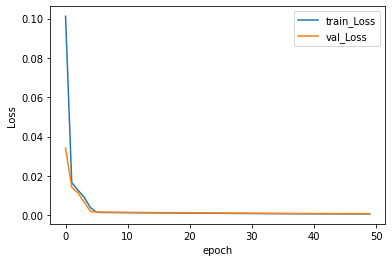

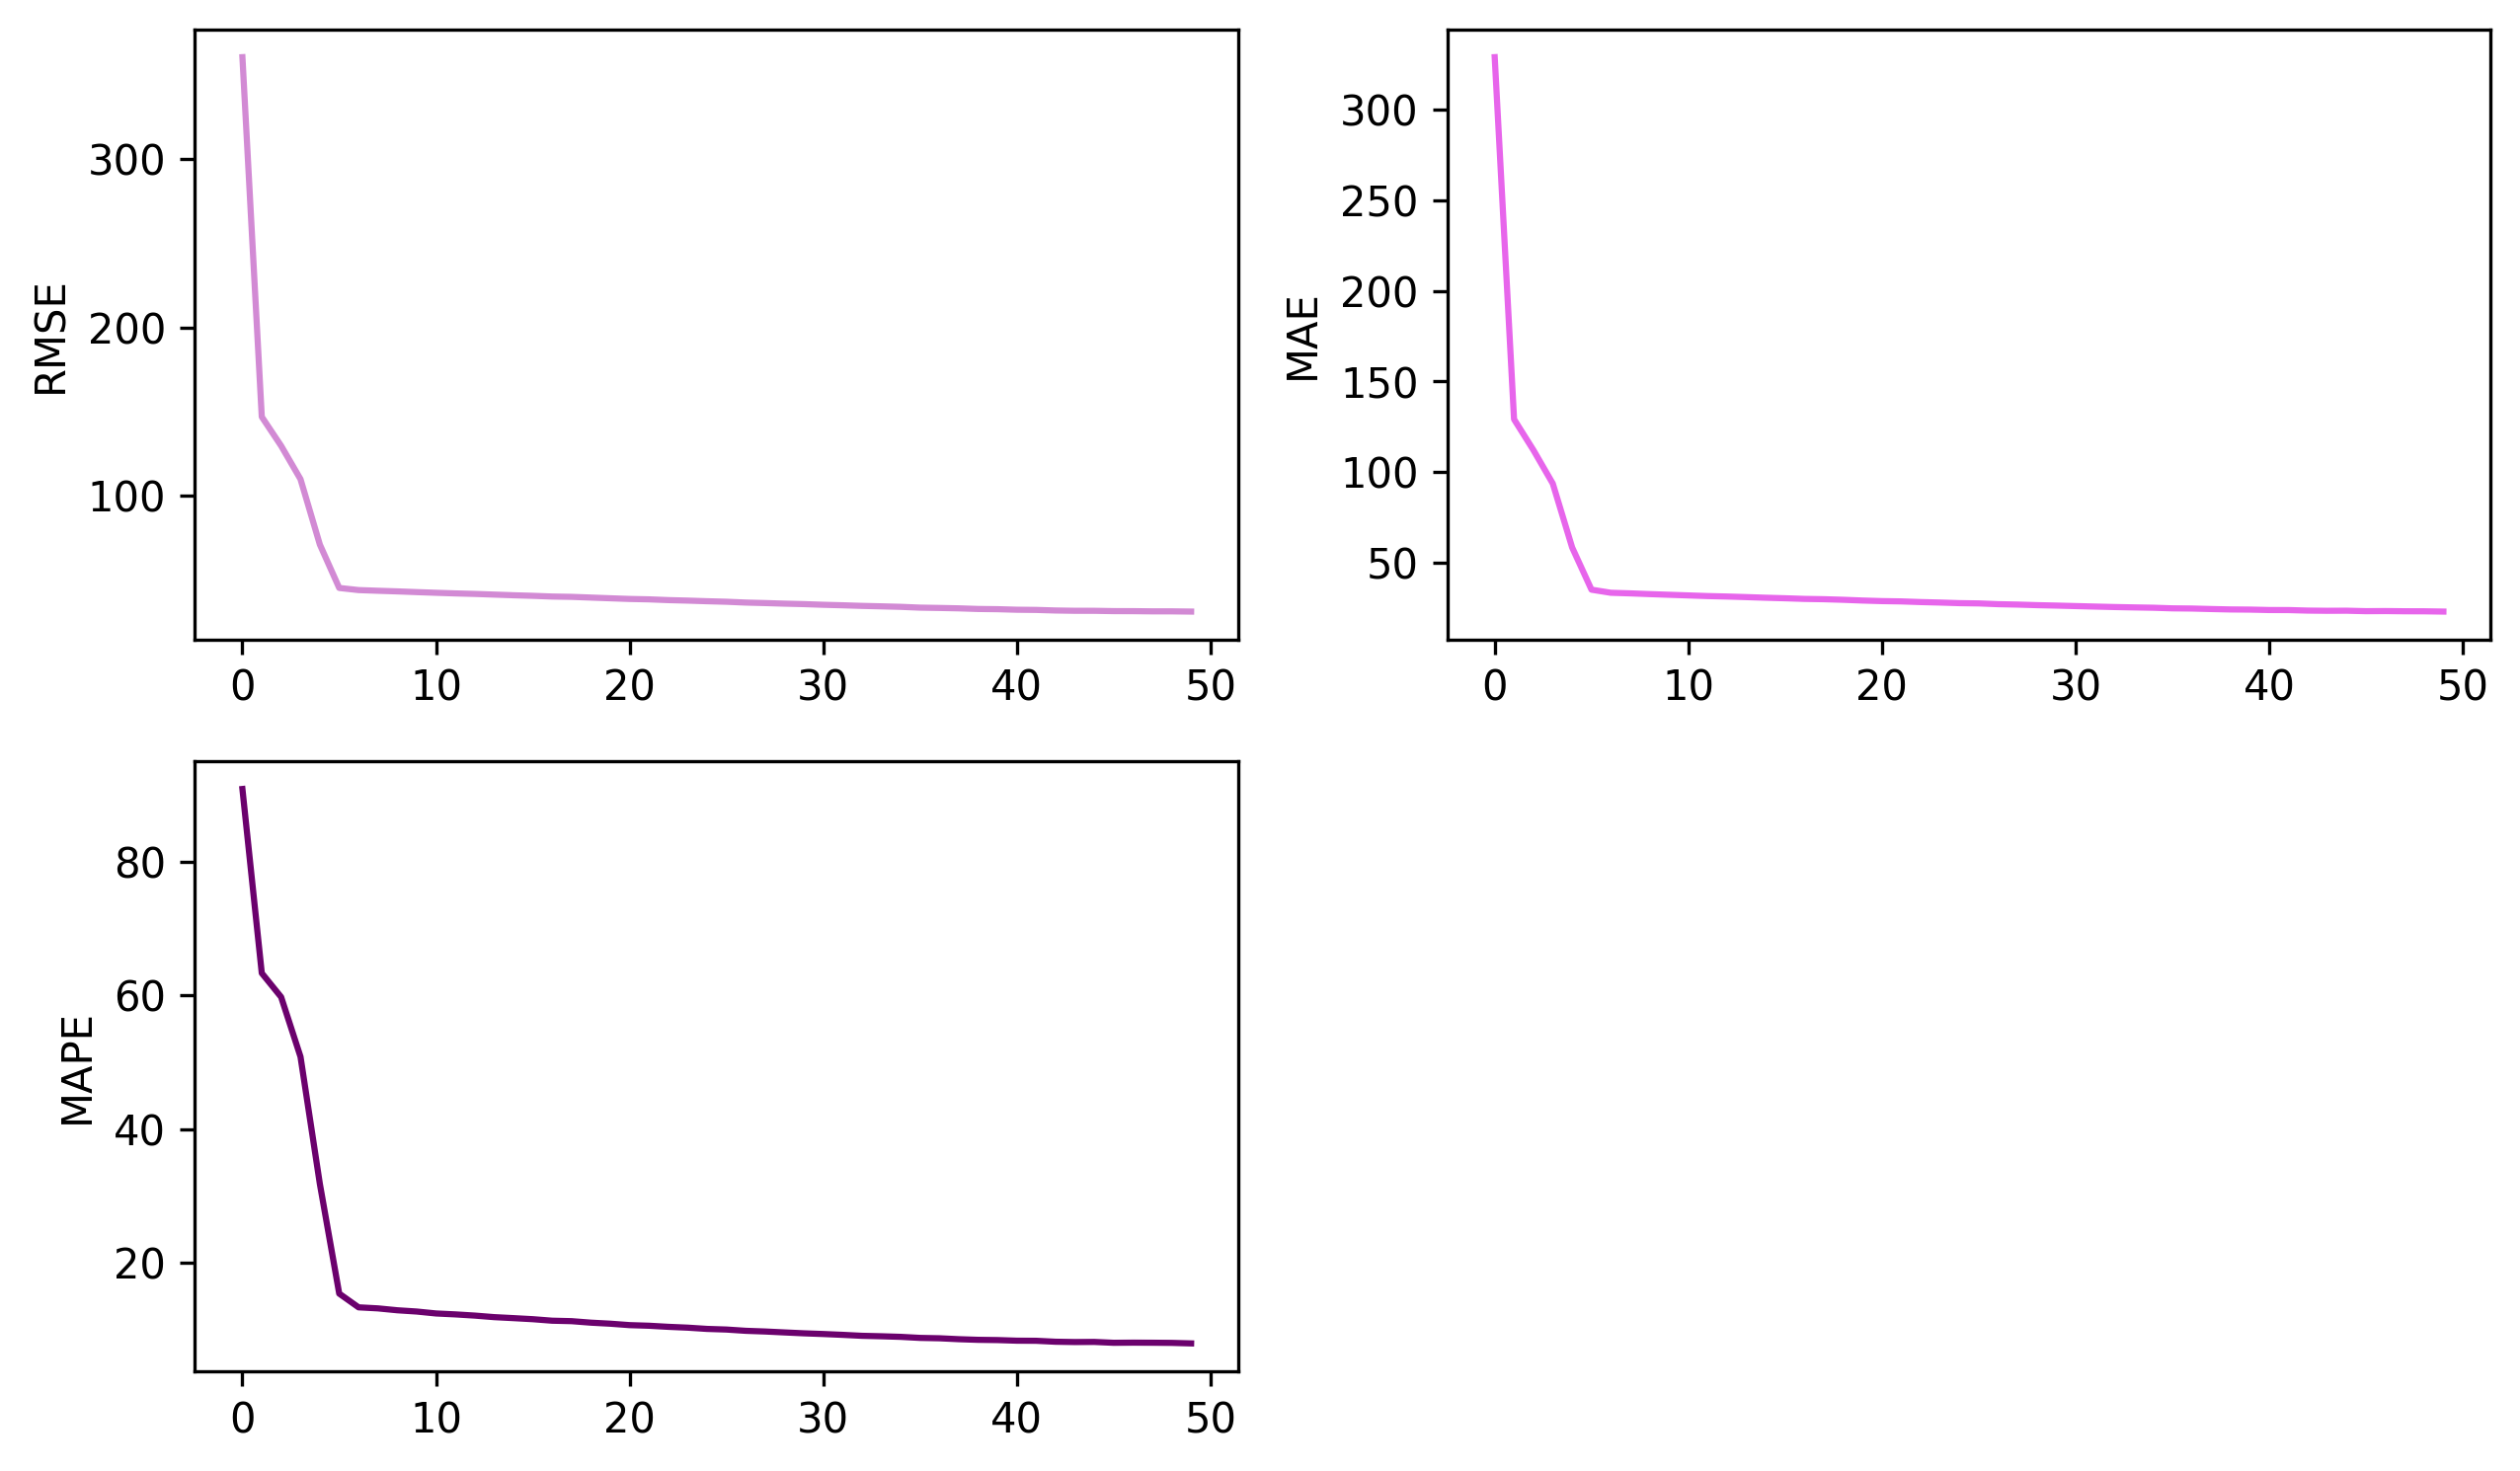

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

修改hidden_size为64

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst_h2, val_loss_lst_h2, \
    train_score_lst_h2, val_score_lst_h2, stop_epoch_h2 = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=40, device=device, output_model=out_linear)

*** epoch1, train loss 0.0464, train rmse 235.0046, val loss 0.0152, val rmse 133.357948, time use 0.888s
*** epoch2, train loss 0.0134, train rmse 132.1647, val loss 0.0115, val rmse 115.109024, time use 0.558s
*** epoch3, train loss 0.0083, train rmse 103.1186, val loss 0.0046, val rmse 71.060689, time use 0.470s
*** epoch4, train loss 0.0024, train rmse 55.1290, val loss 0.0019, val rmse 47.302413, time use 0.473s
*** epoch5, train loss 0.0017, train rmse 46.8565, val loss 0.0018, val rmse 46.406087, time use 0.459s
*** epoch6, train loss 0.0016, train rmse 45.9384, val loss 0.0018, val rmse 45.626314, time use 0.438s
*** epoch7, train loss 0.0016, train rmse 45.0347, val loss 0.0017, val rmse 44.837340, time use 0.446s
*** epoch8, train loss 0.0015, train rmse 44.1421, val loss 0.0016, val rmse 44.268036, time use 0.439s
*** epoch9, train loss 0.0015, train rmse 43.3904, val loss 0.0016, val rmse 44.044223, time use 0.458s
*** epoch10, train loss 0.0014, train rmse 42.4414, val los

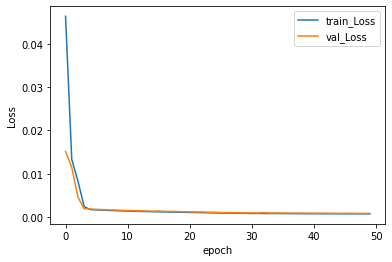

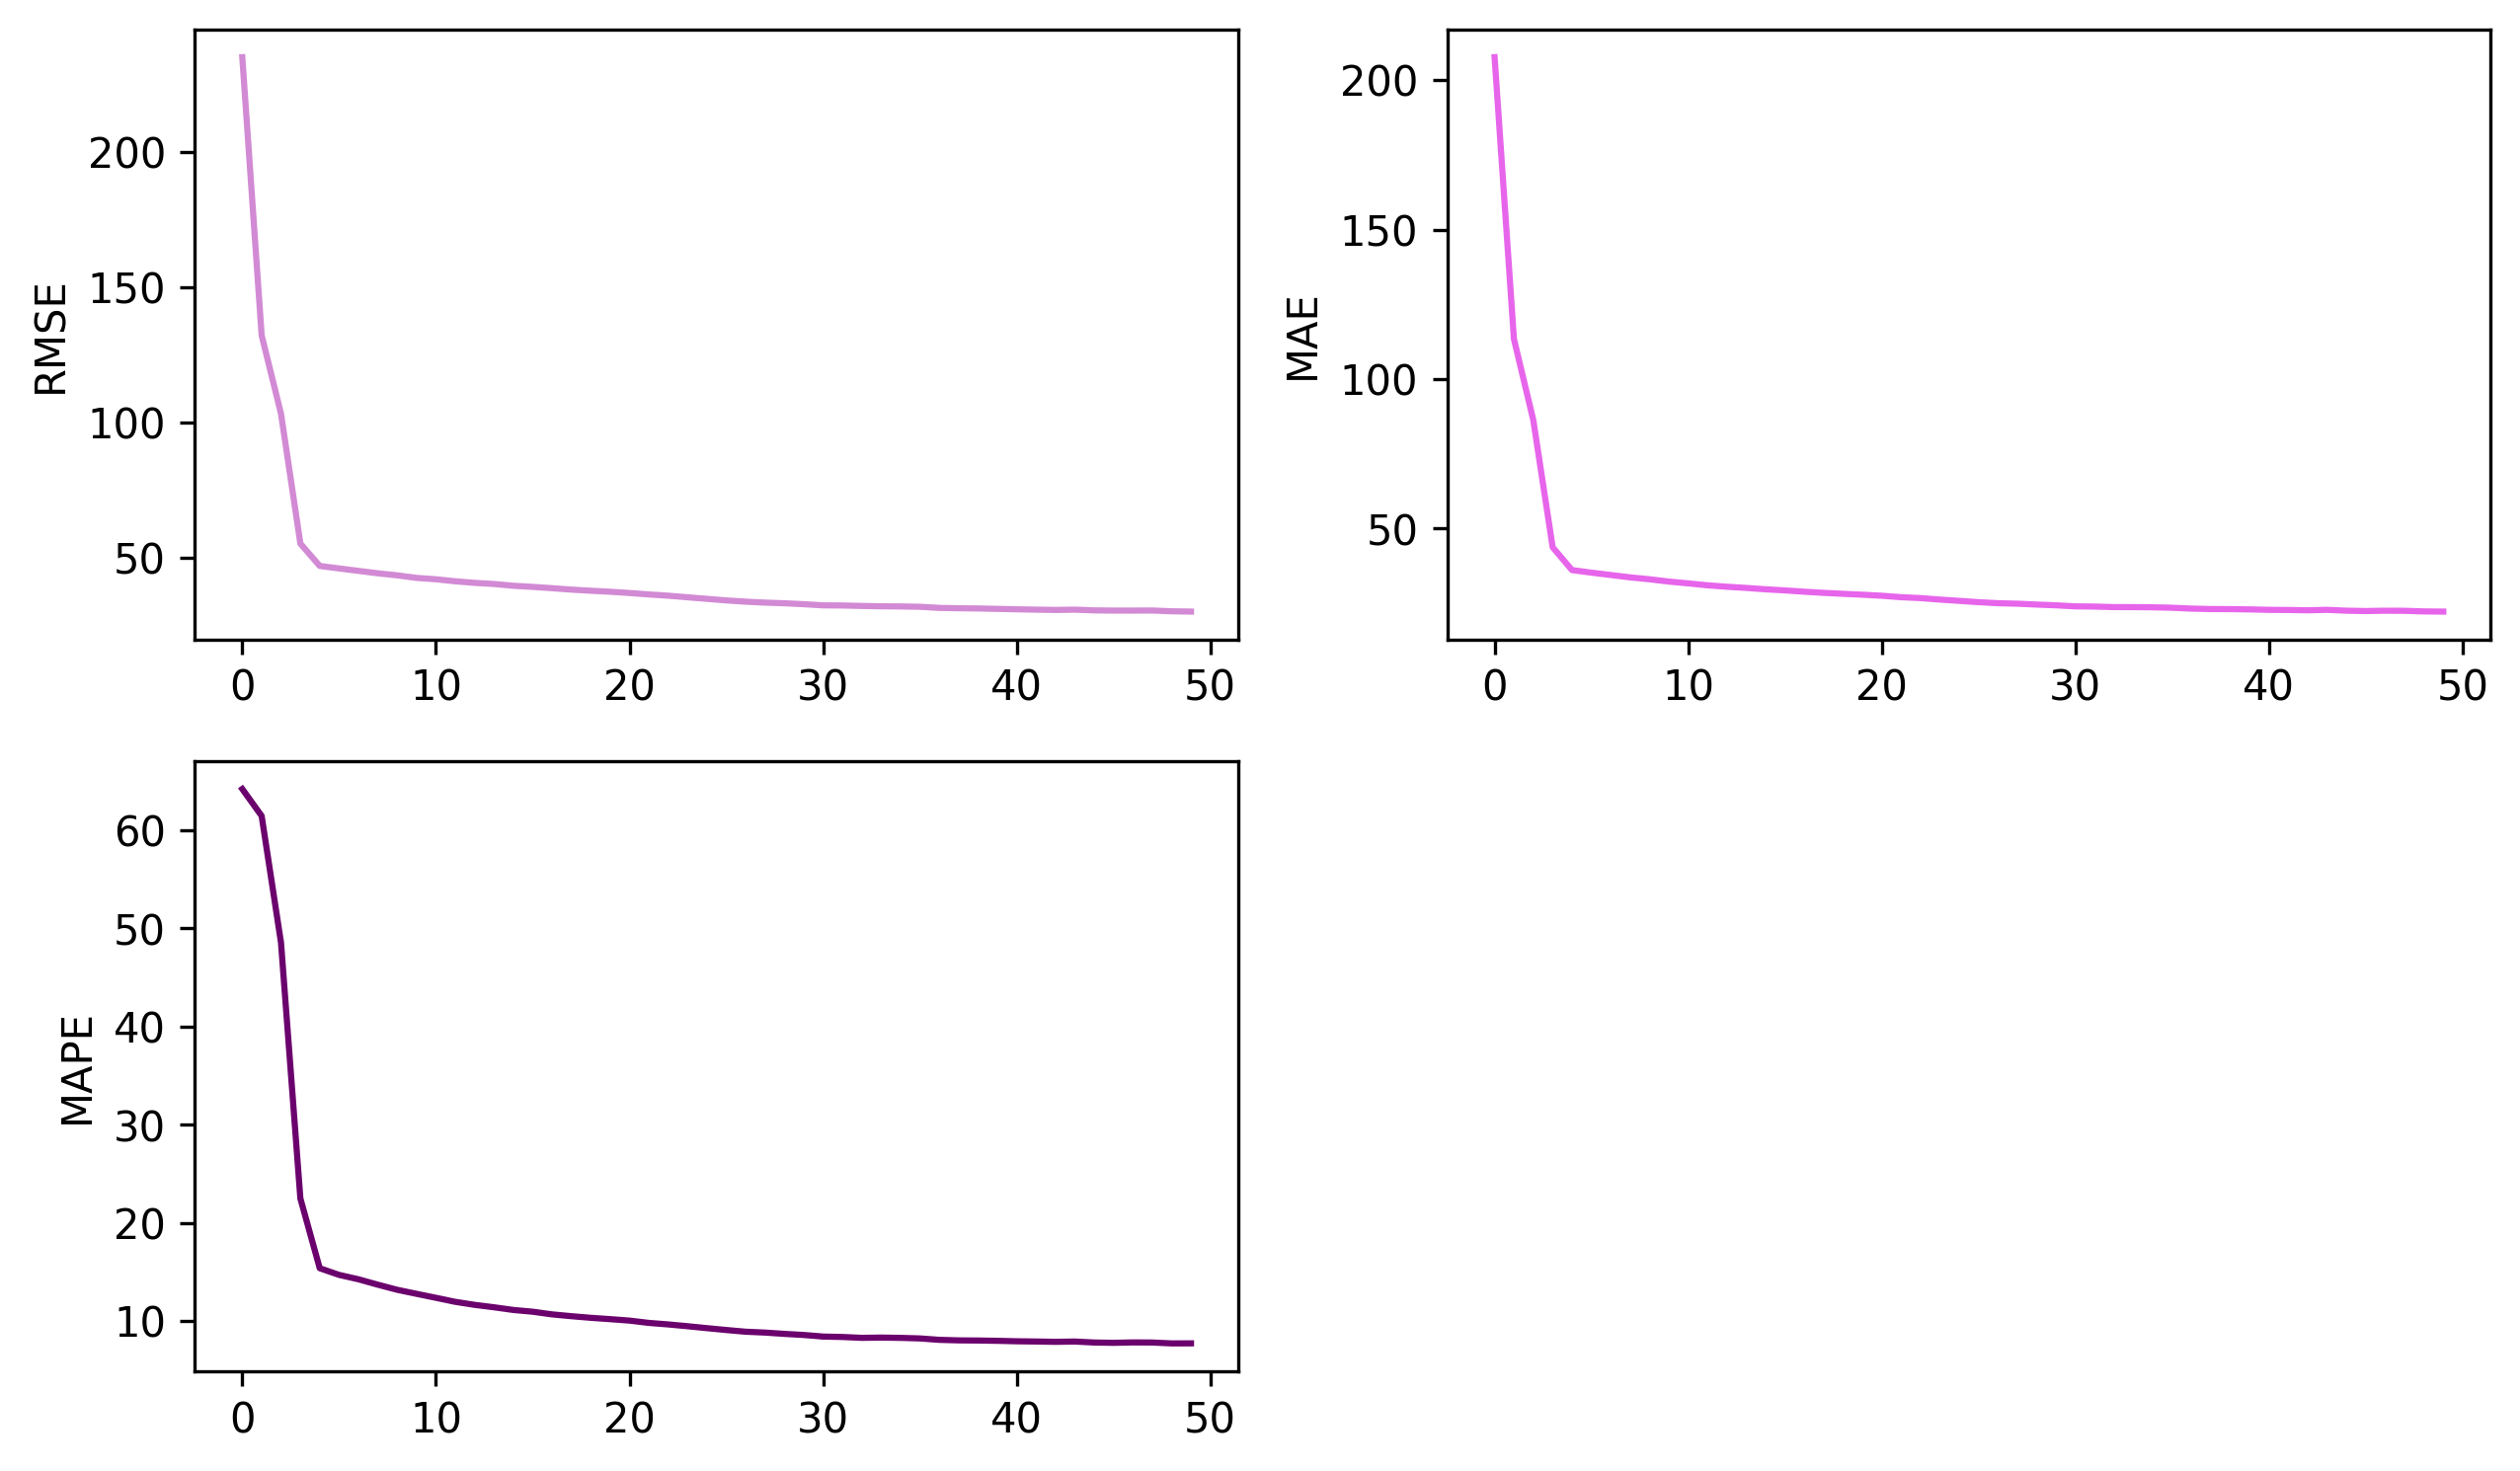

In [ ]:
visualize(stop_epoch_h2, train_loss_lst_h2, val_loss_lst_h2, y_label='Loss')
plot_metric(train_score_lst_h2)

修改hidden_size为128

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 128
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst_h3, val_loss_lst_h3, \
    train_score_lst_h3, val_score_lst_h3, stop_epoch_h3 = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=40, device=device, output_model=out_linear)

*** epoch1, train loss 0.0356, train rmse 198.8554, val loss 0.0116, val rmse 116.164860, time use 0.428s
*** epoch2, train loss 0.0067, train rmse 91.0049, val loss 0.0022, val rmse 51.015625, time use 0.428s
*** epoch3, train loss 0.0018, train rmse 47.9704, val loss 0.0019, val rmse 46.959271, time use 0.436s
*** epoch4, train loss 0.0017, train rmse 46.3970, val loss 0.0018, val rmse 46.470381, time use 0.434s
*** epoch5, train loss 0.0016, train rmse 45.2081, val loss 0.0017, val rmse 45.743438, time use 0.425s
*** epoch6, train loss 0.0015, train rmse 44.2961, val loss 0.0016, val rmse 44.080912, time use 0.426s
*** epoch7, train loss 0.0015, train rmse 43.2707, val loss 0.0016, val rmse 43.281248, time use 0.428s
*** epoch8, train loss 0.0014, train rmse 42.3531, val loss 0.0015, val rmse 42.559725, time use 0.423s
*** epoch9, train loss 0.0013, train rmse 41.5413, val loss 0.0015, val rmse 42.251915, time use 0.415s
*** epoch10, train loss 0.0013, train rmse 40.7735, val loss 0

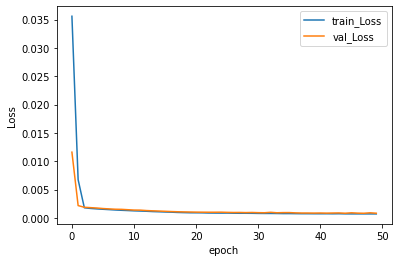

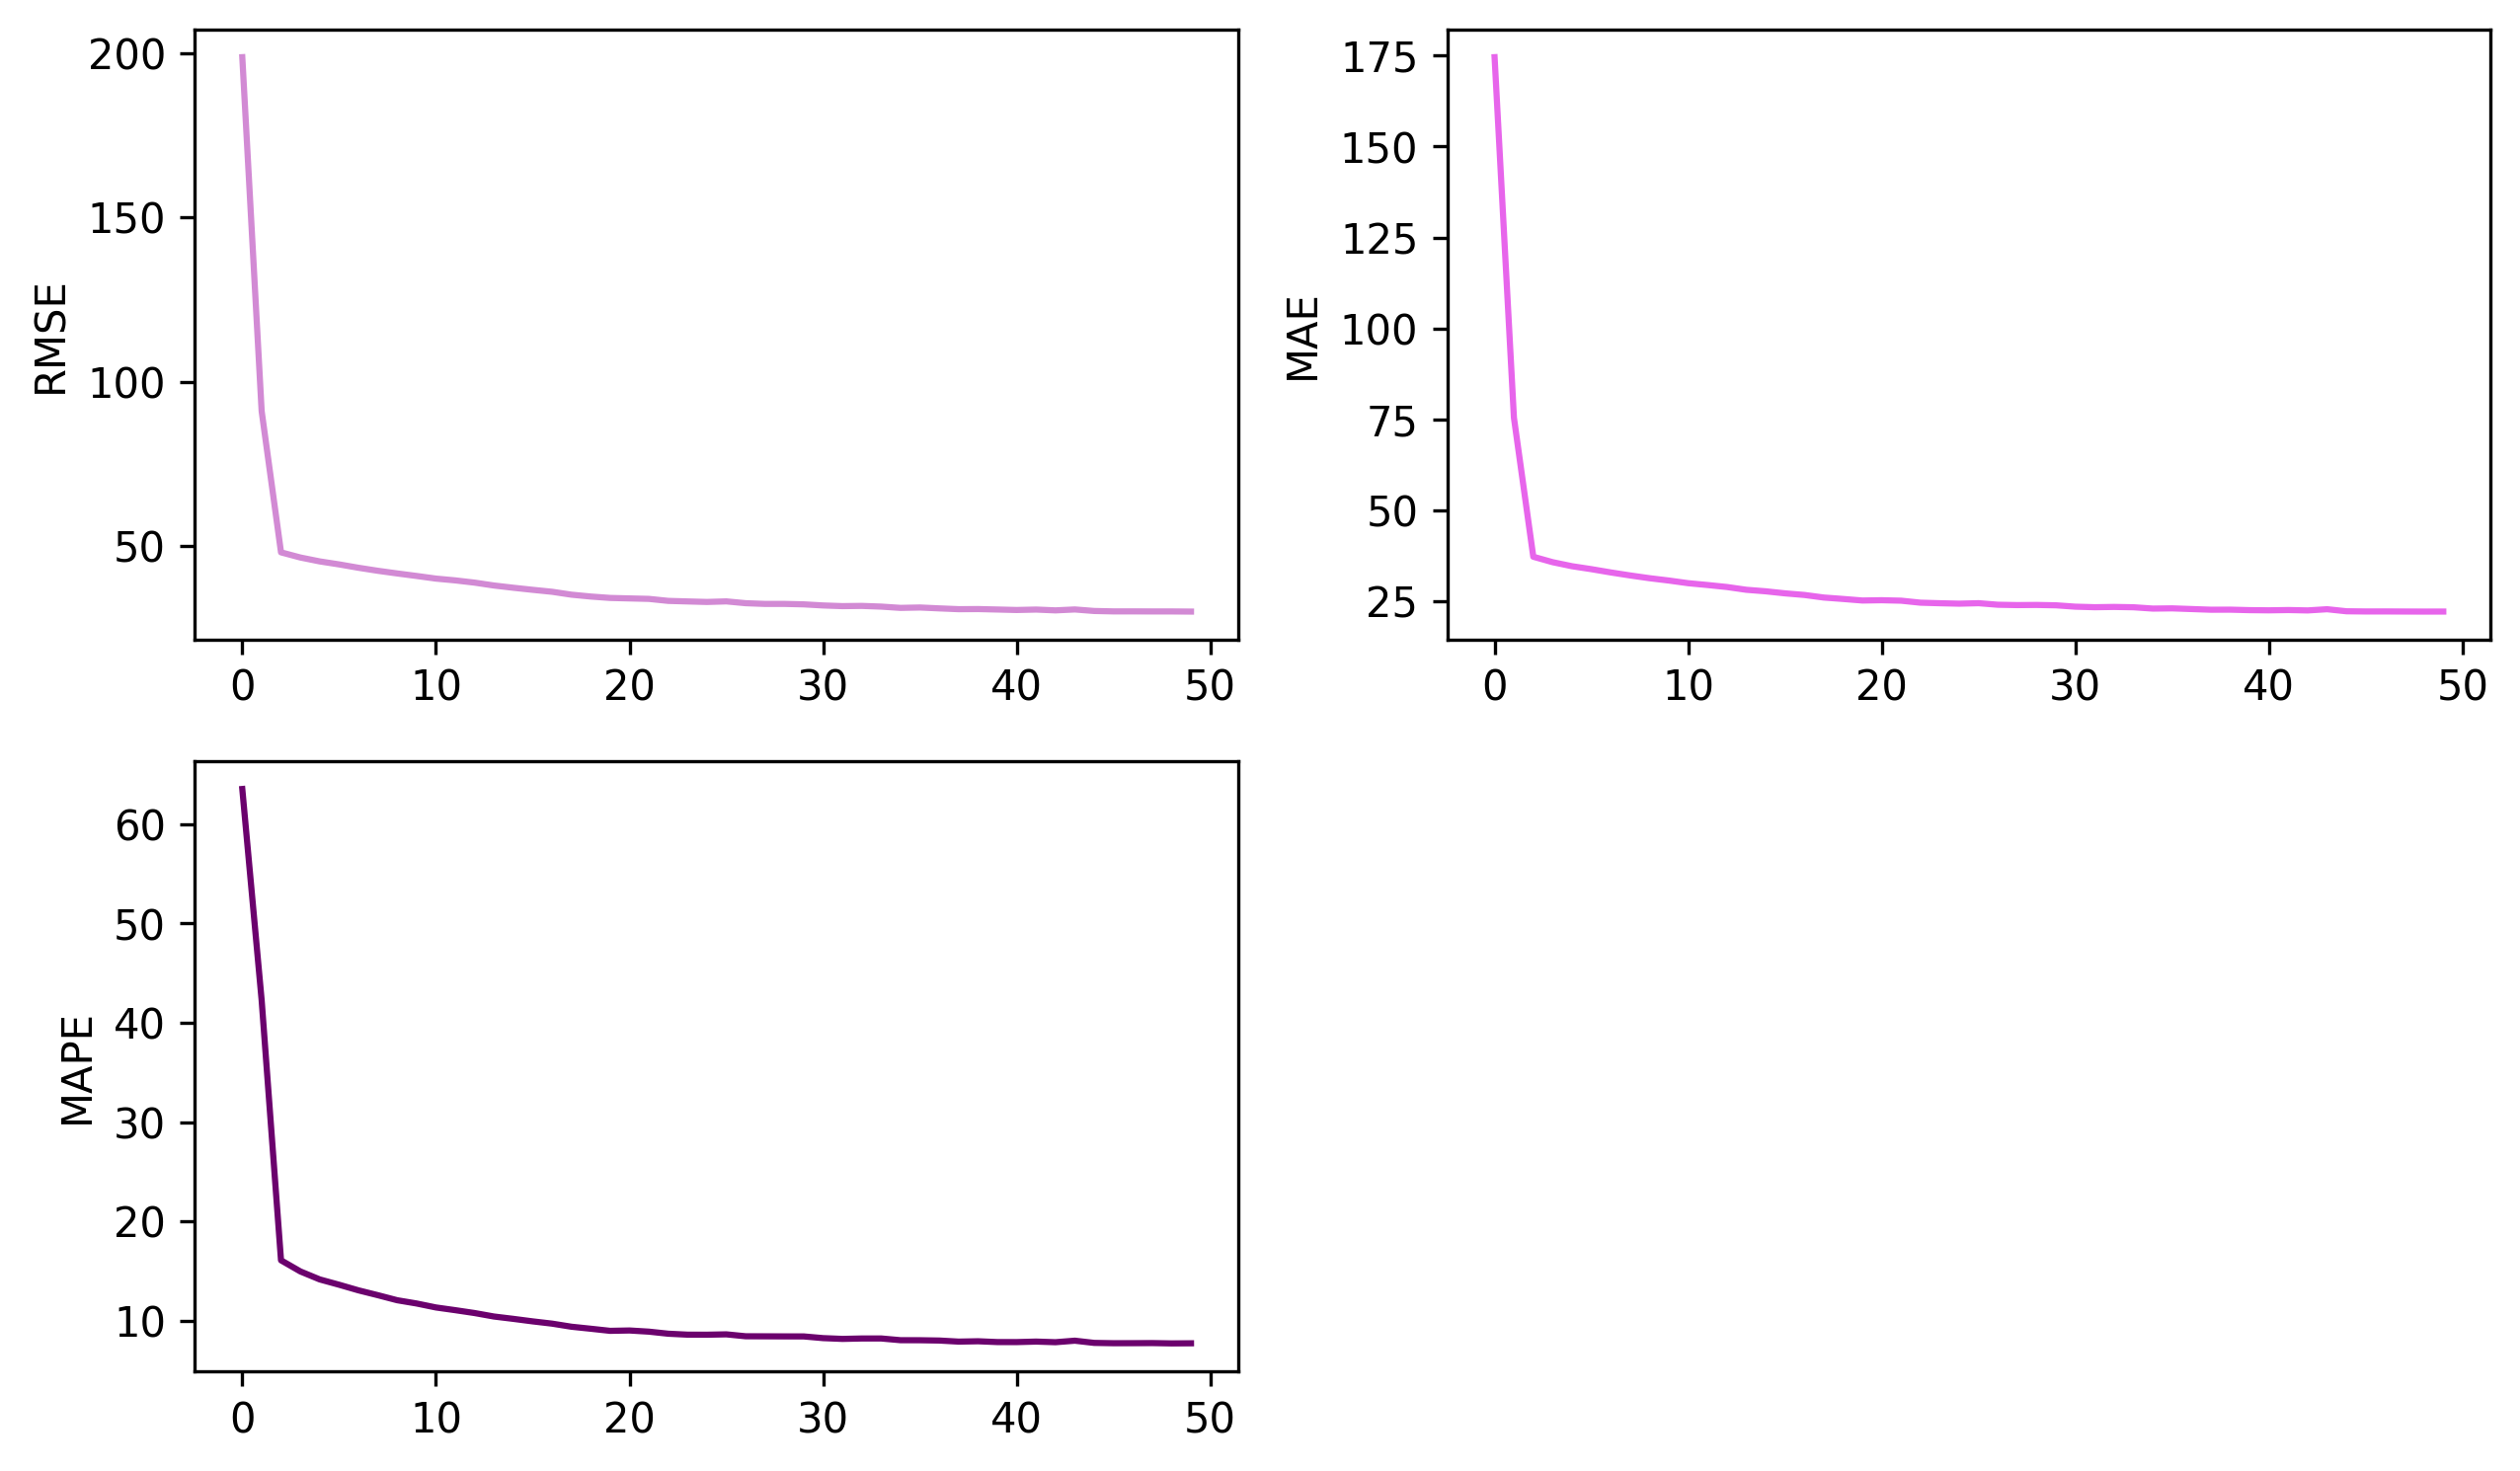

In [ ]:
visualize(stop_epoch_h3, train_loss_lst_h3, val_loss_lst_h3, y_label='Loss')
plot_metric(train_score_lst_h3)

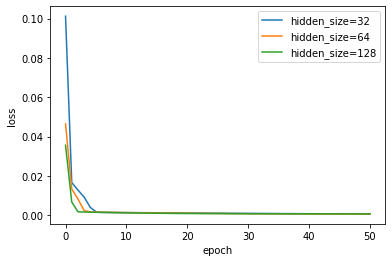

In [ ]:
Draw_Curve([train_loss_lst,"hidden_size=32"],[train_loss_lst_h2,"hidden_size=64"],[train_loss_lst_h3,"hidden_size=128"])

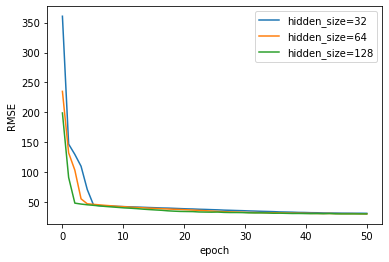

In [ ]:
dataa = np.array(train_score_lst)
data_h2 = np.array(train_score_lst_h2)
data_h3 = np.array(train_score_lst_h3)

#RMSE
Draw_Curve([dataa[:,0],"hidden_size=32"],[data_h2[:,0],"hidden_size=64"],
           [data_h3[:,0],"hidden_size=128"],ylabel = "RMSE")


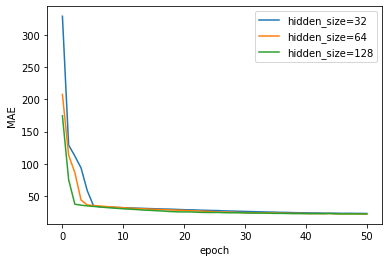

In [ ]:
#MAE
Draw_Curve([dataa[:,1],"hidden_size=32"],[data_h2[:,1],"hidden_size=64"],
           [data_h3[:,1],"hidden_size=128"],ylabel = "MAE")


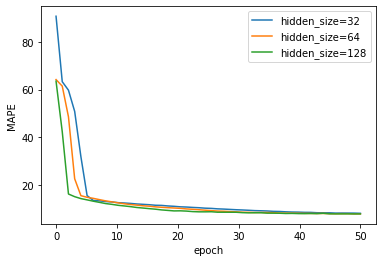

In [ ]:
#MAPE
Draw_Curve([dataa[:,2],"hidden_size=32"],[data_h2[:,2],"hidden_size=64"],
           [data_h3[:,2],"hidden_size=128"],ylabel = "MAPE")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 128
output_size = 1
seq_len = 12
lr = 0.001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst_l2, val_loss_lst_l2, \
    train_score_lst_l2, val_score_lst_l2, stop_epoch_l2 = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=40, device=device, output_model=out_linear)

*** epoch1, train loss 0.0077, train rmse 81.5471, val loss 0.0013, val rmse 40.211084, time use 0.426s
*** epoch2, train loss 0.0011, train rmse 38.0743, val loss 0.0012, val rmse 37.669294, time use 0.443s
*** epoch3, train loss 0.0010, train rmse 35.5461, val loss 0.0011, val rmse 36.355692, time use 0.432s
*** epoch4, train loss 0.0009, train rmse 33.9843, val loss 0.0009, val rmse 33.932594, time use 0.432s
*** epoch5, train loss 0.0008, train rmse 32.3933, val loss 0.0009, val rmse 33.271170, time use 0.444s
*** epoch6, train loss 0.0008, train rmse 31.4659, val loss 0.0010, val rmse 34.783652, time use 0.435s
*** epoch7, train loss 0.0007, train rmse 31.0352, val loss 0.0008, val rmse 31.784065, time use 0.471s
*** epoch8, train loss 0.0007, train rmse 30.1798, val loss 0.0008, val rmse 31.259976, time use 0.441s
*** epoch9, train loss 0.0007, train rmse 29.4970, val loss 0.0008, val rmse 30.675757, time use 0.427s
*** epoch10, train loss 0.0007, train rmse 29.5490, val loss 0.0

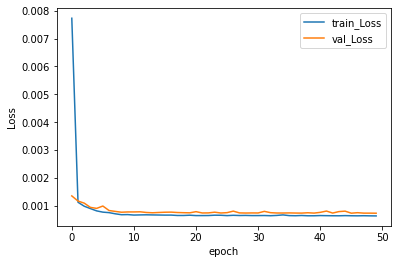

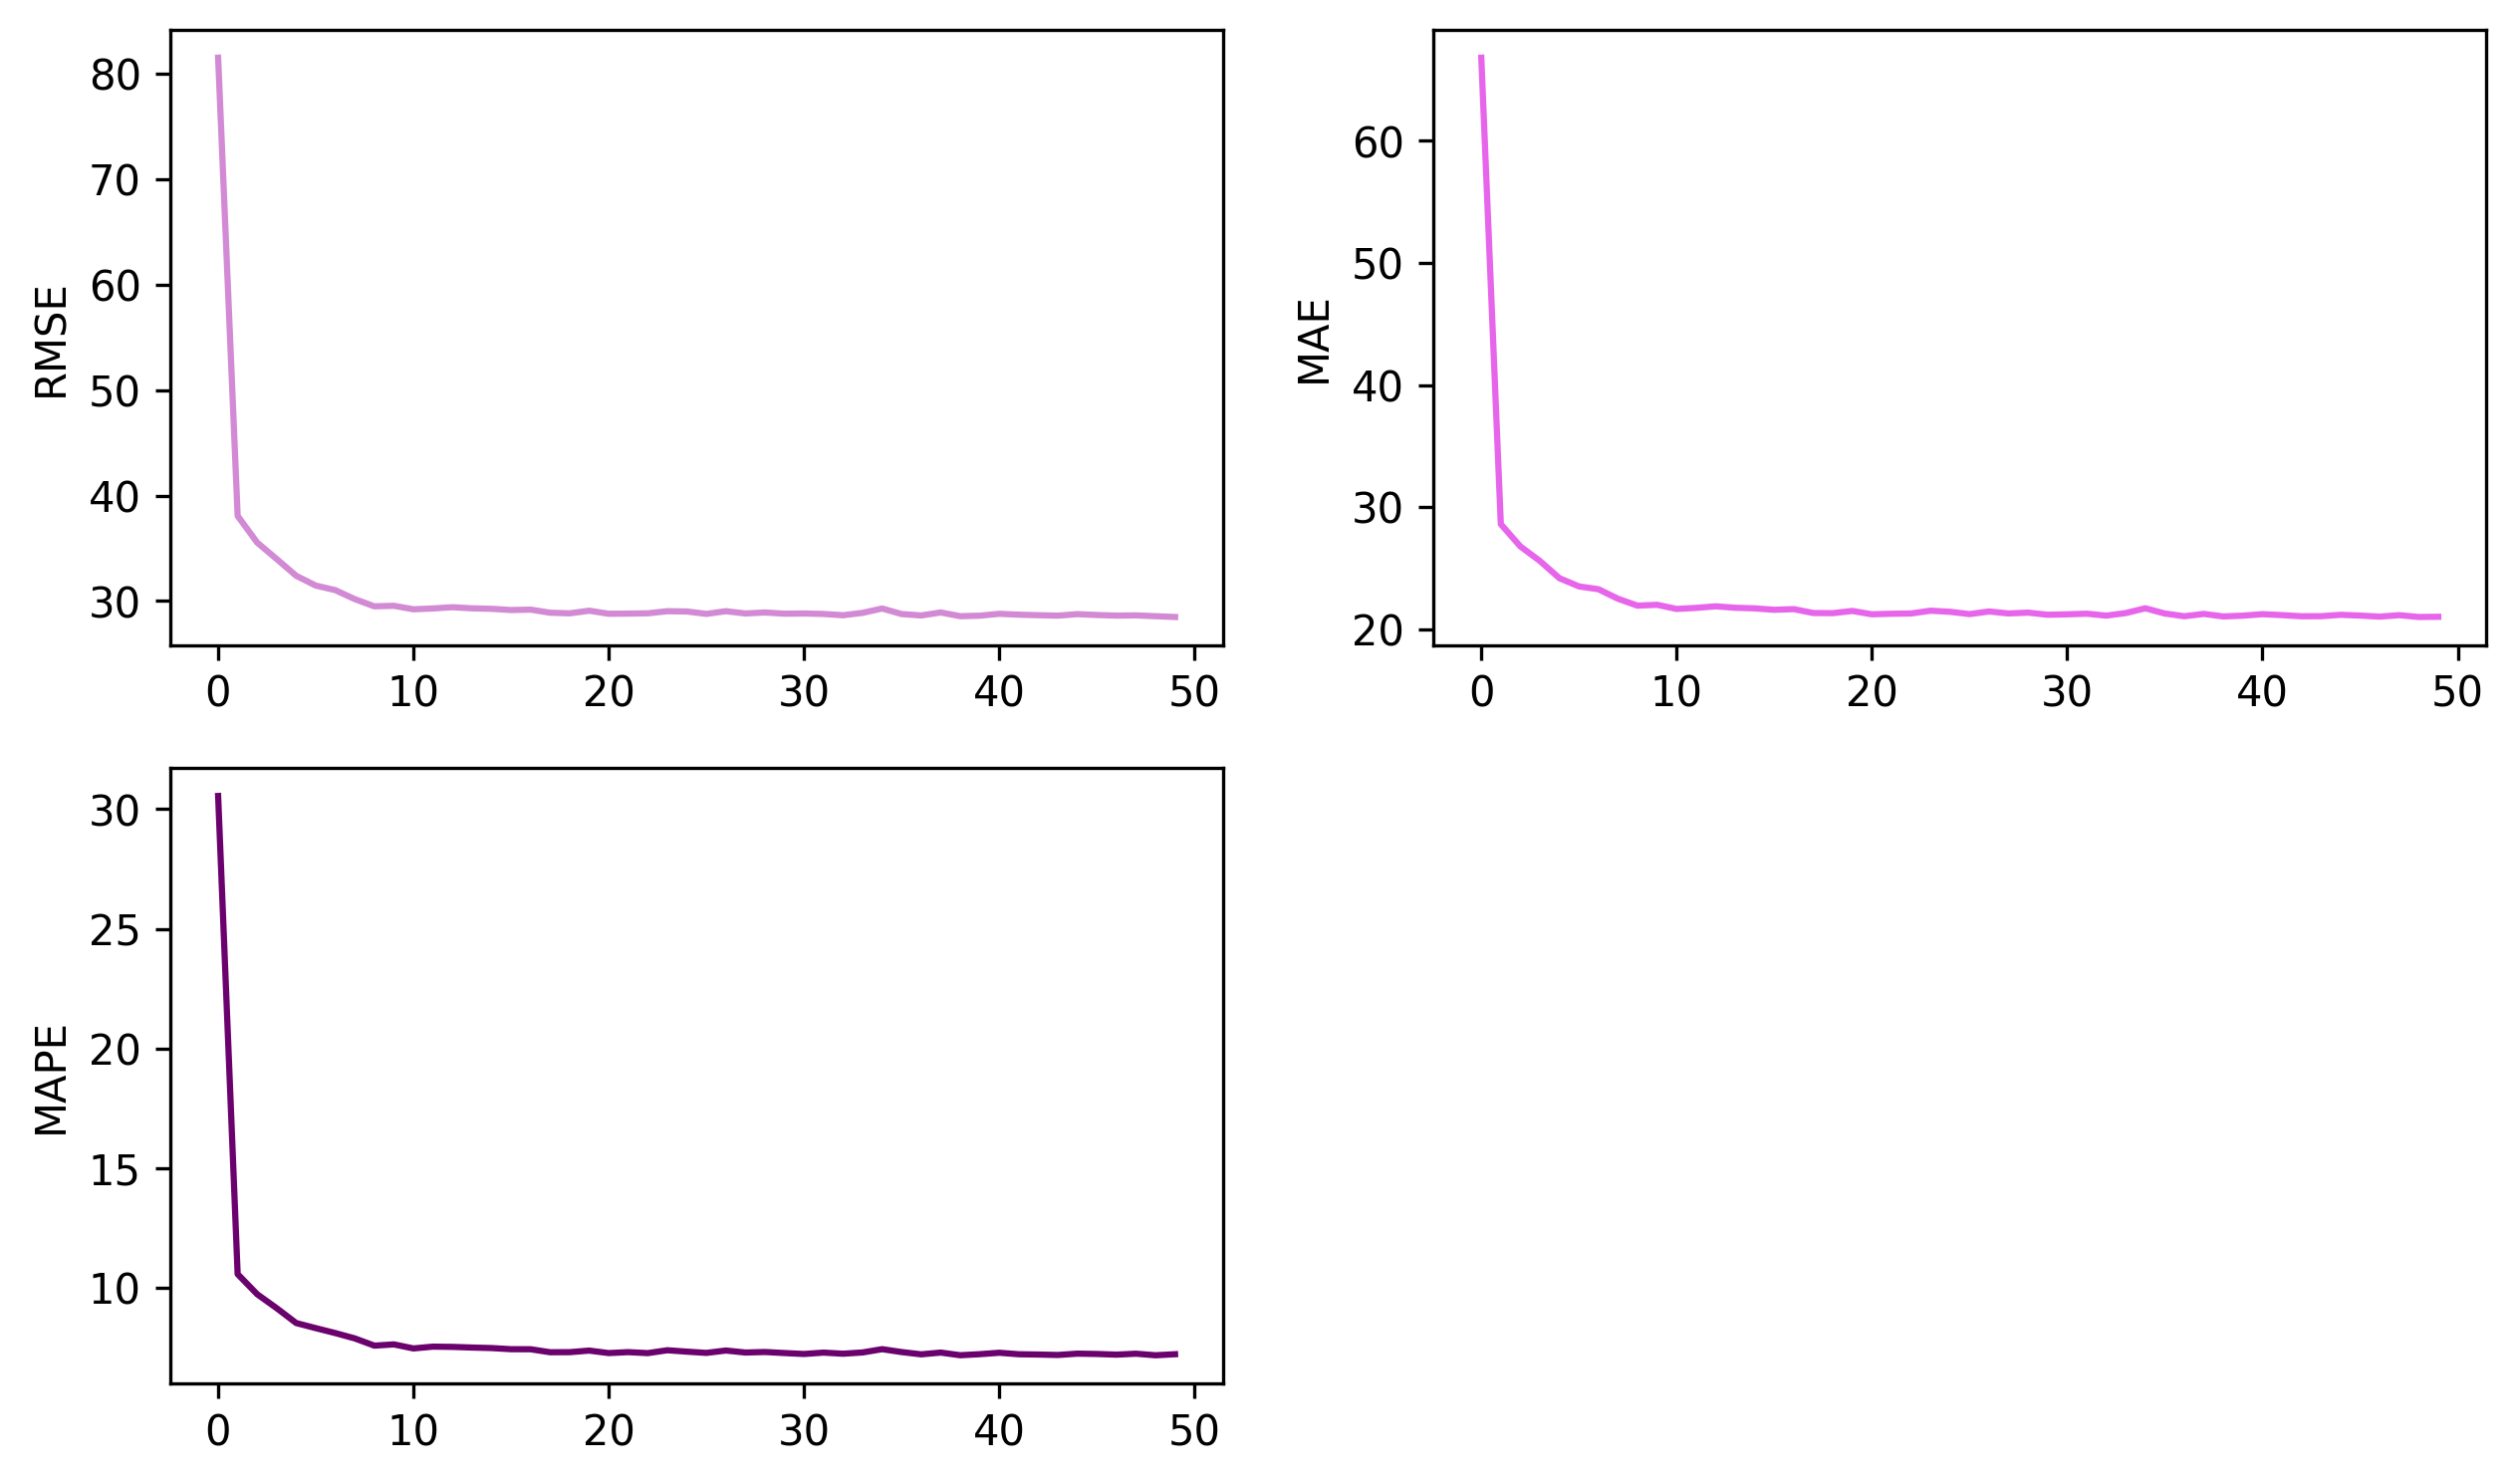

In [ ]:
visualize(stop_epoch_l2, train_loss_lst_l2, val_loss_lst_l2, y_label='Loss')
plot_metric(train_score_lst_l2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 128
output_size = 1
seq_len = 12
lr = 0.0005
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst_l3, val_loss_lst_l3, \
    train_score_lst_l3, val_score_lst_l3, stop_epoch_l3 = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=40, device=device, output_model=out_linear)

*** epoch1, train loss 0.0160, train rmse 121.9486, val loss 0.0018, val rmse 45.518742, time use 0.437s
*** epoch2, train loss 0.0014, train rmse 42.4569, val loss 0.0014, val rmse 41.074243, time use 0.456s
*** epoch3, train loss 0.0012, train rmse 39.4369, val loss 0.0013, val rmse 40.043383, time use 0.429s
*** epoch4, train loss 0.0011, train rmse 37.8142, val loss 0.0014, val rmse 41.226158, time use 0.435s
*** epoch5, train loss 0.0010, train rmse 36.1118, val loss 0.0011, val rmse 36.352190, time use 0.433s
*** epoch6, train loss 0.0009, train rmse 34.5423, val loss 0.0010, val rmse 35.147179, time use 0.437s
*** epoch7, train loss 0.0009, train rmse 33.7822, val loss 0.0010, val rmse 34.243954, time use 0.439s
*** epoch8, train loss 0.0008, train rmse 33.0839, val loss 0.0011, val rmse 36.503466, time use 0.425s
*** epoch9, train loss 0.0008, train rmse 32.3790, val loss 0.0010, val rmse 34.588917, time use 0.433s
*** epoch10, train loss 0.0008, train rmse 32.0560, val loss 0.

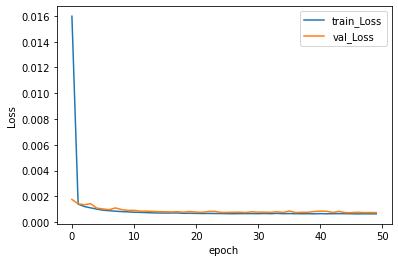

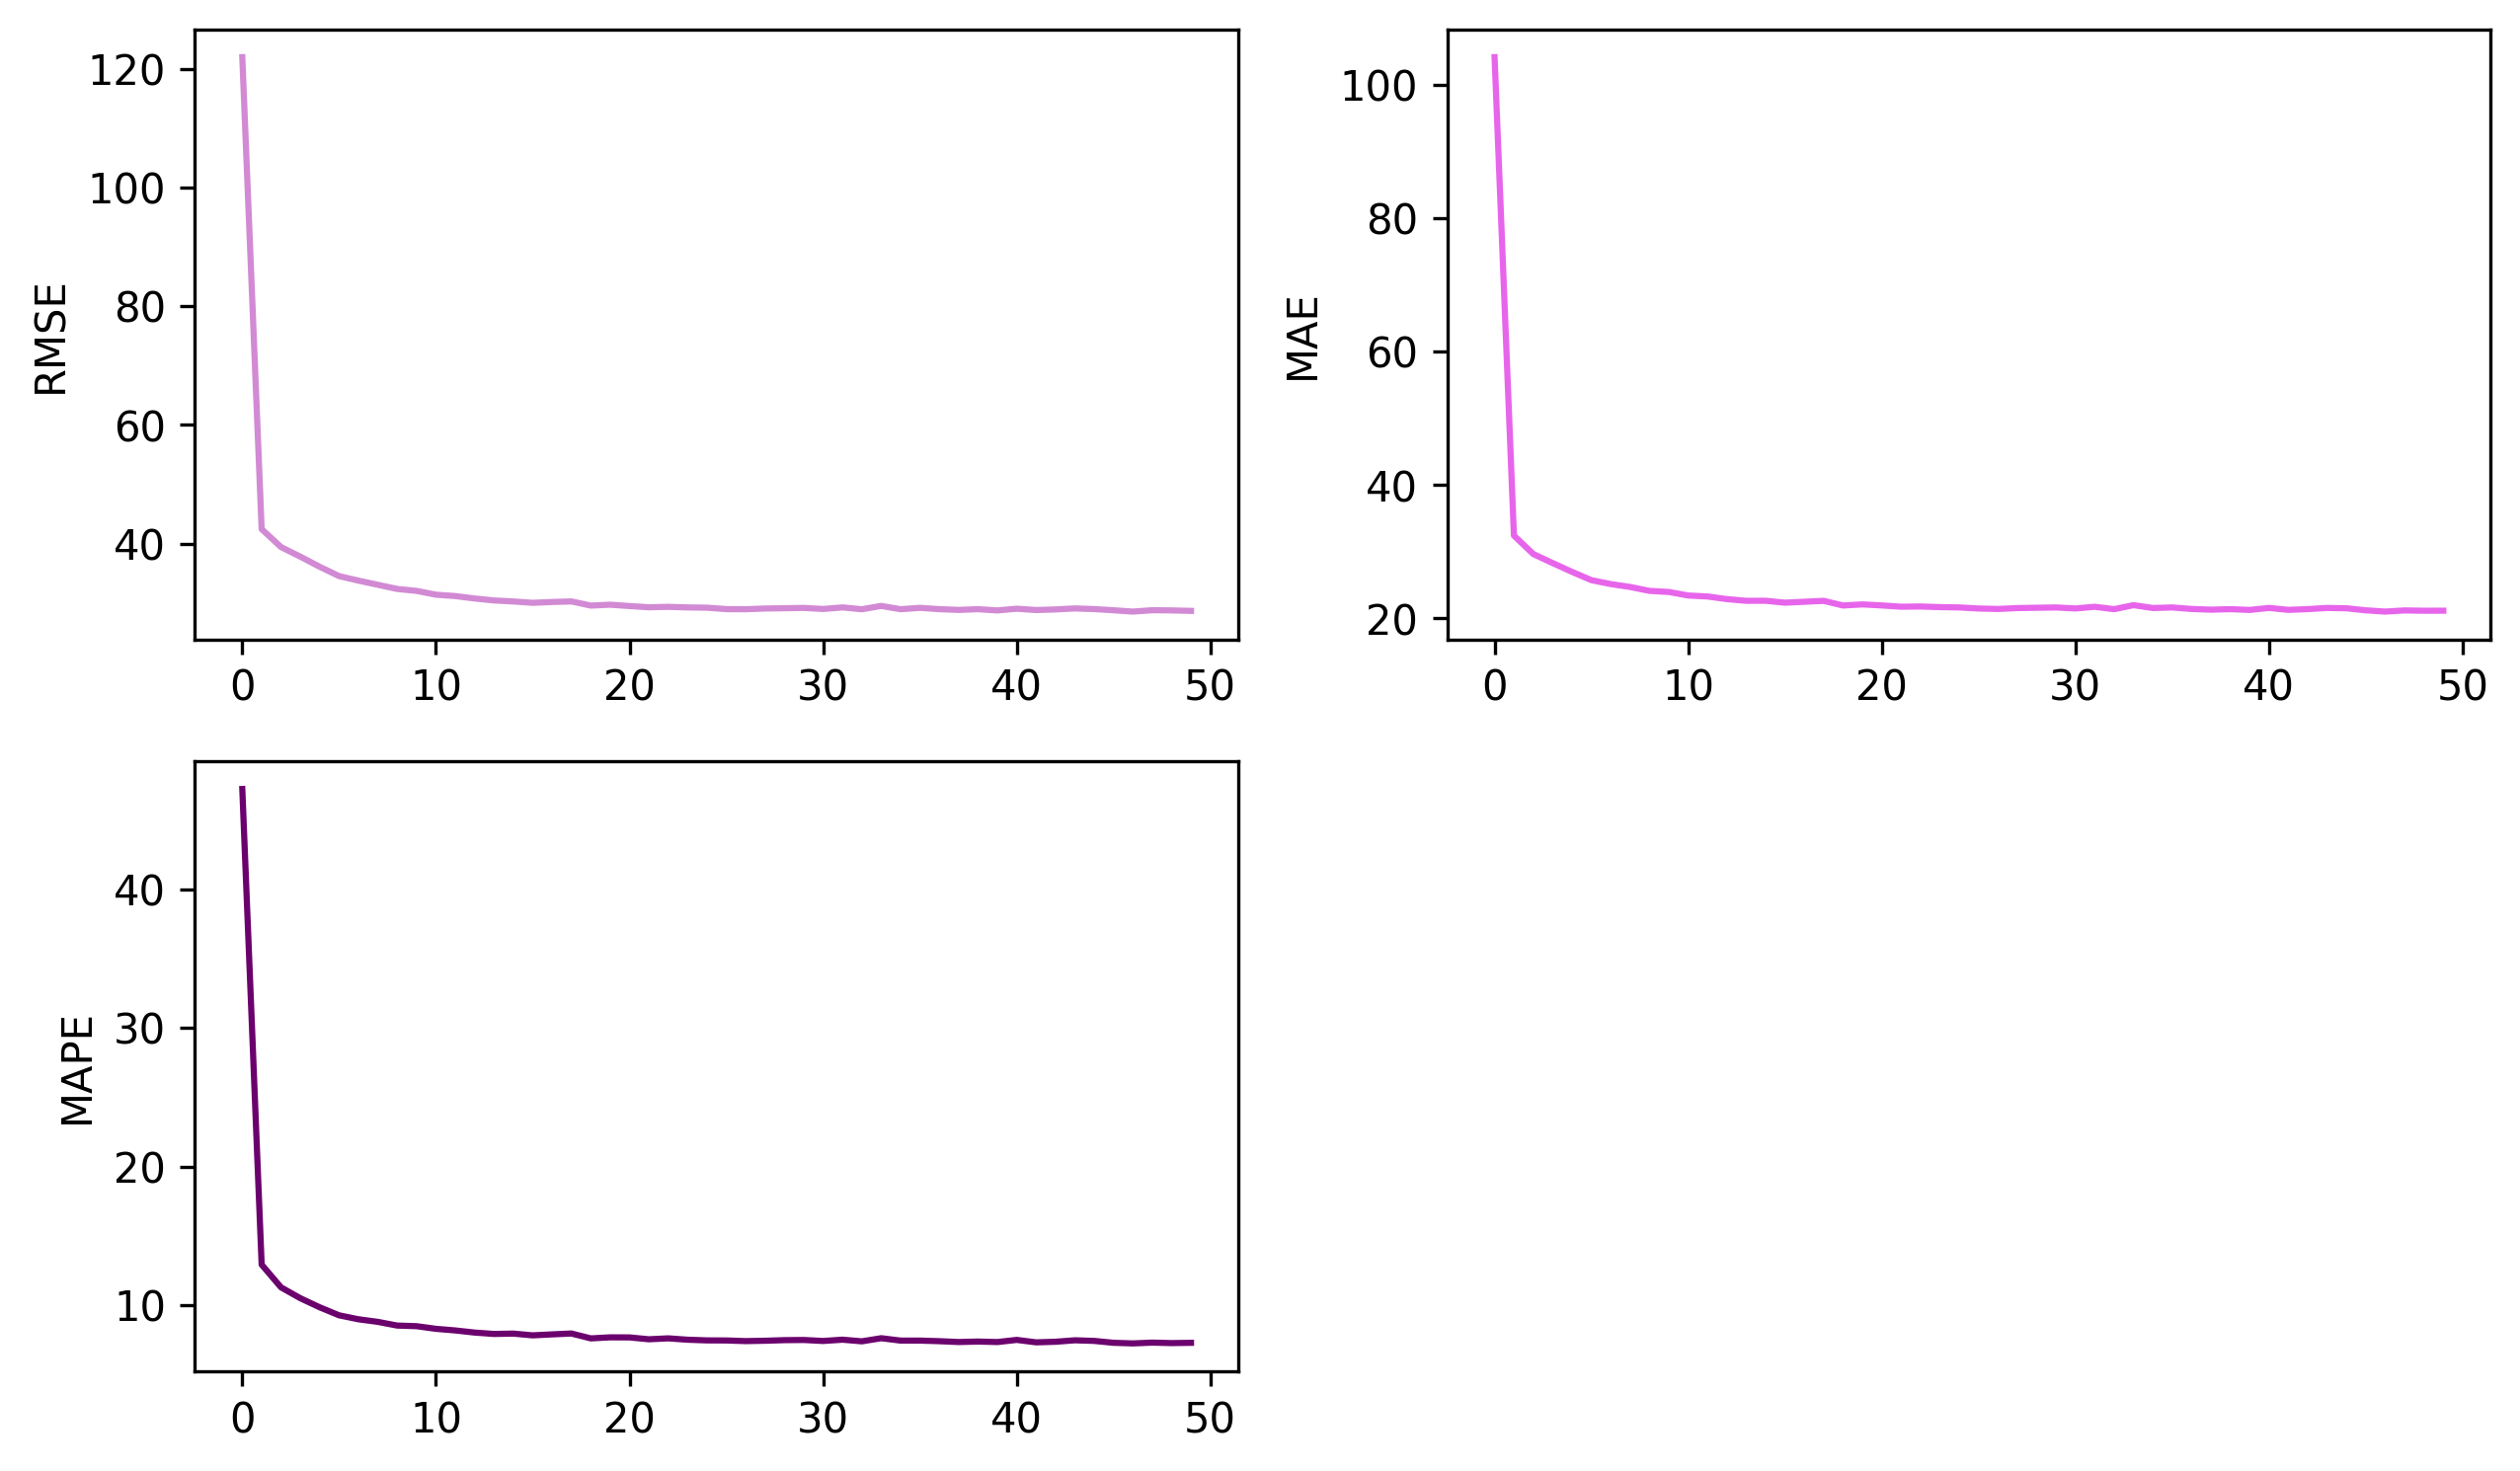

In [ ]:
visualize(stop_epoch_l3, train_loss_lst_l3, val_loss_lst_l3, y_label='Loss')
plot_metric(train_score_lst_l3)

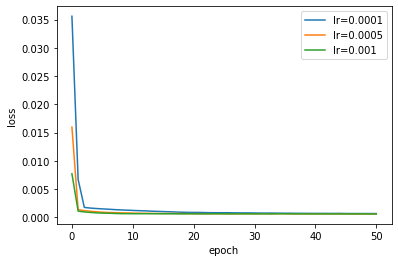

In [ ]:
Draw_Curve([train_loss_lst_h3,"lr=0.0001"],[train_loss_lst_l3,"lr=0.0005"],[train_loss_lst_l2,"lr=0.001"])

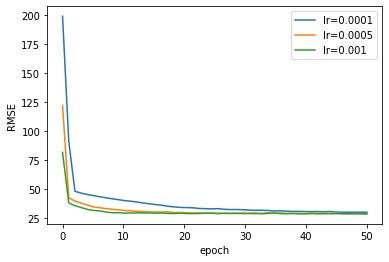

In [ ]:
dataa = np.array(train_score_lst_h3)
data_l2 = np.array(train_score_lst_l2)
data_l3 = np.array(train_score_lst_l3)

#RMSE
Draw_Curve([dataa[:,0],"lr=0.0001"],[data_l3[:,0],"lr=0.0005"],
           [data_l2[:,0],"lr=0.001"],ylabel = "RMSE")


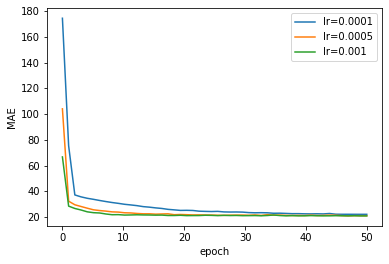

In [ ]:
#MAE
Draw_Curve([dataa[:,1],"lr=0.0001"],[data_l3[:,1],"lr=0.0005"],
           [data_l2[:,1],"lr=0.001"],ylabel = "MAE")


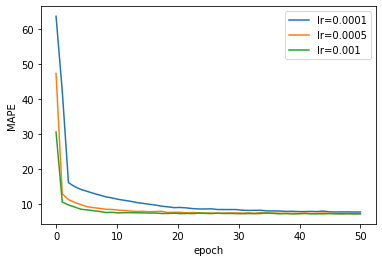

In [ ]:
#MAPE
Draw_Curve([dataa[:,2],"lr=0.0001"],[data_l3[:,2],"lr=0.0005"],
           [data_l2[:,2],"lr=0.001"],ylabel = "MAPE")